In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

2025-05-21 07:23:09.322028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747812189.534455      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747812189.595395      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Загрузка и предобработка данных

# Loading data from the 'mnist_compressed.npz' file
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data('/kaggle/input/mnist-orig/mnist.npz')

In [3]:
# Масштабирование и нормализация
x_train = tf.image.resize(tf.expand_dims(x_train, -1), [128, 128]) / 255.0
x_test = tf.image.resize(tf.expand_dims(x_test, -1), [128, 128]) / 255.0

# One-hot кодирование меток
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

I0000 00:00:1747812248.734756      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747812248.735426      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# Построение модели VGG
model = Sequential([
    Input(shape=(128, 128, 1)),
    # Блок 1
    Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'),
    Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
    # Блок 2
    Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
    # Блок 3
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'),
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'),
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),
    # Блок 4
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),
    # Блок 5
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'),
    # Полносвязные слои
    Flatten(name='flatten'),
    Dense(4096, activation='relu', name='fc1'),
    Dropout(0.5),
    Dense(4096, activation='relu', name='fc2'),
    Dropout(0.5),
    Dense(10, activation='softmax', name='predictions')
])

In [5]:
# Компиляция модели
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
# Выводим сводку модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 65,094,346 (248.32 MB)

 Trainable params: 65,094,346 (248.32 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Обучение модели
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10


I0000 00:00:1747812357.397545      98 service.cc:148] XLA service 0x7da300007a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747812357.398316      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747812357.398345      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747812357.801062      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747812403.772622      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 410s 854ms/step - accuracy: 0.4191 - loss: 1.6049 - val_accuracy: 0.9848 - val_loss: 0.0508
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 284s 673ms/step - accuracy: 0.9773 - loss: 0.0749 - val_accuracy: 0.9892 - val_loss: 0.0395
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 284s 674ms/step - accuracy: 0.9867 - loss: 0.0441 - val_accuracy: 0.9928 - val_loss: 0.0281
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 284s 673ms/step - accuracy: 0.9909 - loss: 0.0322 - val_accuracy: 0.9928 - val_loss: 0.0255
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 284s 674ms/step - accuracy: 0.9926 - loss: 0.0225 - val_accuracy: 0.9925 - val_loss: 0.0283
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 284s 674ms/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.9923 - val_loss: 0.0283
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 284s 674ms/step - accuracy: 0.9943 - loss: 0.0180 - val_accuracy: 0.9940 - val_loss: 0.0222
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 284s 674ms/step - accuracy: 0.9956 - loss: 0.01

In [8]:
model.save("vgg_mnist.h5")  # Сохраняем модель

In [9]:
scores = model.evaluate(x_test, y_test)
print(f'Test loss: {scores[0]:.4f}')
print(f'Test accuracy: {scores[1]:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step - accuracy: 0.9909 - loss: 0.0347
Test loss: 0.0282
Test accuracy: 0.9933


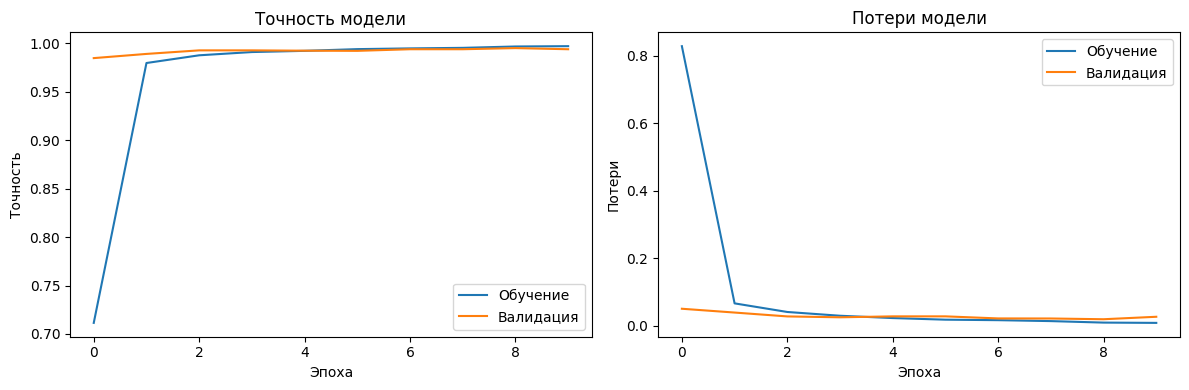

In [10]:
# Визуализация процесса обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend(['Обучение', 'Валидация'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Потери модели')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend(['Обучение', 'Валидация'], loc='upper right')

plt.tight_layout()
plt.savefig('alexnet_training_history.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


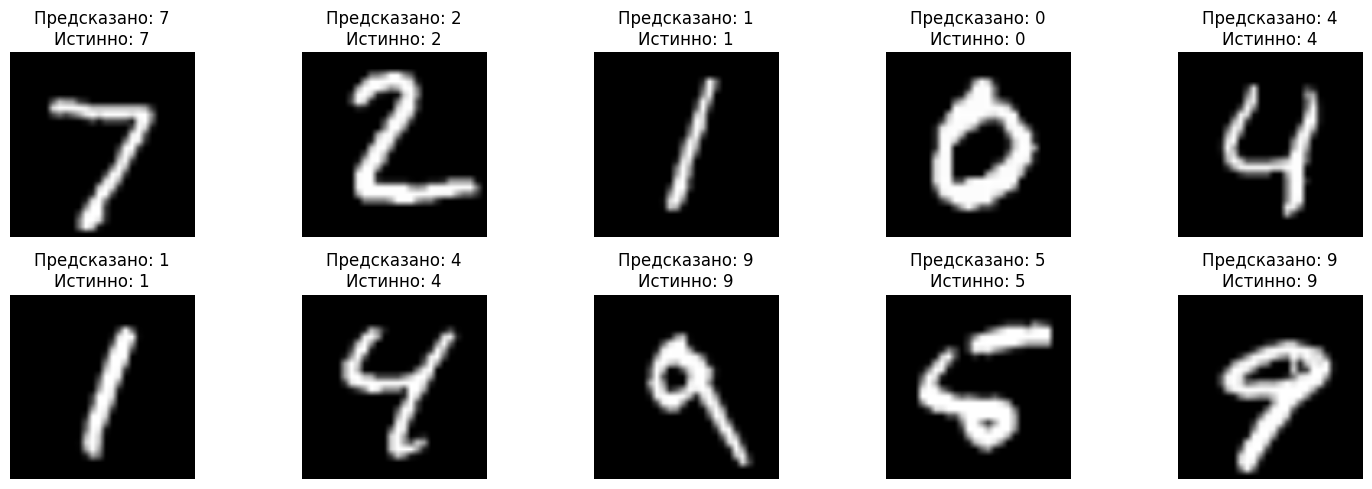

In [11]:
# Визуализация предсказаний
predictions = model.predict(x_test[:10])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:10], axis=1)

# Отображение оригинальных (не масштабированных) изображений
# Поскольку x_test уже 224×224, используем x_test[i]
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    # Показываем в исходном размере (одноканальное изображение)
    plt.imshow(tf.squeeze(x_test[i]), cmap='gray')
    plt.title(f"Предсказано: {predicted_classes[i]}\nИстинно: {true_classes[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()